## Cuboid waveguide - Discussion

In [1]:
import os
import sys
import fenics as fen
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
from cuboid_waveguide import CuboidWaveguide
import src.helpers as helpers

### Dimensions and properties

<Figure size 432x288 with 0 Axes>

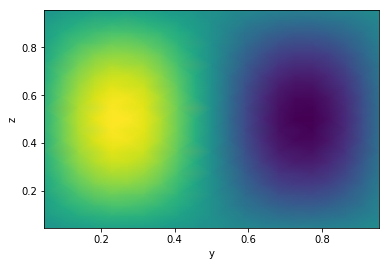

In [3]:
Lx, Ly, Lz = 5.0, 1.0, 1.0
Nx, Ny, Nz = 51, 11, 11
m, n = 2, 1
g_N = fen.Expression(('sin(x[1]*m*pi/Ly)*sin(x[2]*n*pi/Lz)', '0.0', '0.0'), degree=2, Ly=Ly, Lz=Lz, m=m, n=n)
WG = CuboidWaveguide(Lx=Lx, Ly=Ly, Lz=Lz, Nx=Nx, Ny=Ny, Nz=Nz, g_N=g_N)
WG.plot_g_N()

### Solution of problem

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


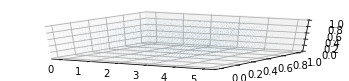

In [4]:
WG.setup()
WG.solve(34.66335)
WG.plot_solution()

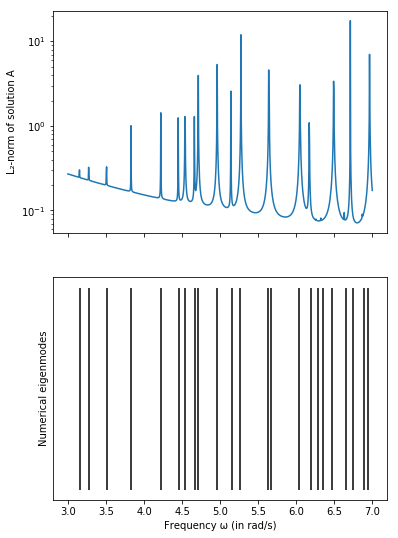

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 9), sharex=True)
omegas = np.linspace(3, 7, 1000)
helpers.plot_L2_norms(ax[0], WG, omegas)
helpers.plot_analytical_eigenfrequencies(ax[1], WG, omegas[0], omegas[-1])
ax[0].set_ylabel('L\u2082-norm of solution A')
ax[1].set_ylabel('Numerical eigenmodes')
ax[1].set_yticks([])
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
plt.show()

In [5]:
eigval, eigvec = helpers.solve_eigenproblem(WG.get_K(), WG.get_M(), a=-np.inf, b=np.inf, k=1, valid_indices=WG.get_valid_indices())

Increase parameter "k" to make sure all eigenvalues are found.


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


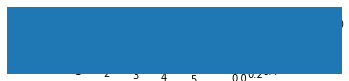

In [6]:
WG.plot_external_solution(eigvec, contains_boundary_values=False, omega=eigval)

### Timing

In [6]:
omega = WG.get_analytical_eigenfrequencies(0, 10)[0]

#### FEniCS solver

In [7]:
LHS = WG.get_K(tosparse=False) - omega**2 * WG.get_M(tosparse=False)
RHS = WG.get_L(get_local=False) + WG.get_N(get_local=False)
A_sol = fen.Function(WG.get_V())
%timeit fen.solve(LHS, A_sol.vector(), RHS)

2.01 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### SciPy sparse Hermitian eigenvalue solver

In [8]:
valid_indices = WG.get_valid_indices()
K = WG.get_K()[valid_indices, :][:, valid_indices]
M = WG.get_M()[valid_indices, :][:, valid_indices]
%timeit scipy.sparse.linalg.eigsh(K, k=1, M=M, sigma=omega**2)

KeyboardInterrupt: 